In [1]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [2]:
from fastai.callback.fp16 import *

In [63]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      get_items = get_image_files,
                      get_y = parent_label,
                      item_tfms=Resize(460),
                      batch_tfms = aug_transforms(size=244, min_scale=.75)
                      )

dls = dblock.dataloaders(path, bs=64)

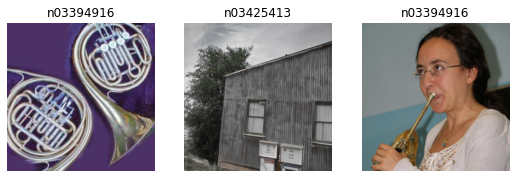

In [4]:
dls.train.show_batch(max_n=3, nrows=1)

In [5]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.574366,1.775162,0.475355,03:42
1,1.207045,1.337745,0.570575,03:36
2,0.960862,1.312706,0.626587,03:37
3,0.747930,0.701928,0.781927,03:37
4,0.620330,0.615251,0.815907,03:37


In [69]:
x,y = dls.one_batch()

In [37]:
x.mean(dim=[0, 2, 3]), x.std(dim=[0, 2, 3])

(TensorImage([0.4730, 0.4690, 0.4475], device='cuda:0'),
 TensorImage([0.2834, 0.2767, 0.3002], device='cuda:0'))

In [3]:
def get_dls(bs, size):
    dblock = DataBlock(
                blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                get_y = parent_label,
                item_tfms=Resize(460),
                batch_tfms=[*aug_transforms(size=size, min_scale=.75),
                            Normalize.from_stats(*imagenet_stats)])
    
    return dblock.dataloaders(path, bs = bs)

In [4]:
dls1 = get_dls(64, 244)

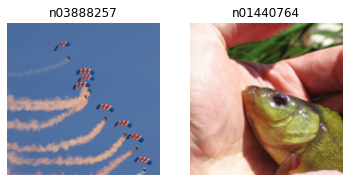

In [76]:
dls1.train.show_batch(max_n=2)

In [85]:
x1, y1 = dls1.one_batch()
x1.mean(dim=[0, 2, 3]), x1.std(dim=[0, 2, 3])

(TensorImage([-0.0882,  0.0343,  0.1441], device='cuda:0'),
 TensorImage([1.2679, 1.2513, 1.3568], device='cuda:0'))

In [87]:
x.mean(dim=[0, 2, 3]), x.std(dim=[0, 2, 3])

(TensorImage([0.4719, 0.4644, 0.4374], device='cuda:0'),
 TensorImage([0.2863, 0.2873, 0.3110], device='cuda:0'))

In [5]:
model = xresnet50(n_out=dls1.c)
learn = Learner(dls1, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.556194,1.788505,0.453697,03:44
1,1.206926,1.532306,0.502987,03:38
2,0.975396,1.042160,0.652353,03:38
3,0.716696,0.677353,0.785661,03:40
4,0.585692,0.587649,0.811800,03:38


## Progressive Resizing

In [14]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(),
                       metrics=accuracy).to_fp16()

learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.617422,2.385876,0.365571,01:18
1,1.222046,1.434071,0.592233,01:11
2,0.943463,0.914495,0.703883,01:12
3,0.742738,0.715403,0.768857,01:12


In [16]:
learn.fine_tune??

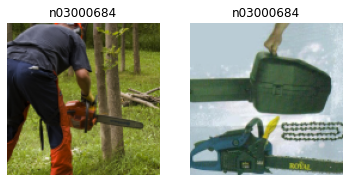

In [42]:
learn.dls.train.show_batch(max_n=2)

In [43]:
learn.dls = get_dls(64, 224)

In [45]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.806112,1.153562,0.665049,03:12


epoch,train_loss,valid_loss,accuracy,time
0,0.623311,0.791866,0.756161,03:05
1,0.667599,0.740531,0.767364,03:05
2,0.588048,0.663045,0.794249,03:05
3,0.496484,0.502839,0.842420,03:06
4,0.422899,0.457467,0.848394,03:05


## Test Time Augmentation

In [50]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.8599701523780823

## Mixup

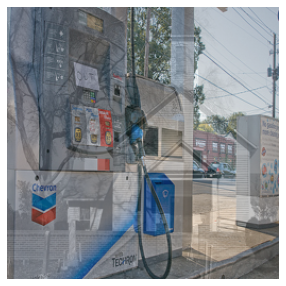

In [70]:
church = PILImage.create(get_image_files(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files(path/'train'/'n03425413')[0])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

# _,axs = plt.subplots(1, 3, figsize=(12,4))
# show_image(tchurch, ax=axs[0]);
# show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas));